# Getting Started with `captum.optim`

This notebook shows how to use the `captum.optim` submodule for visualizing features.

We first introduce the `ImageTensor`, which allows us to easily load and view images. Next, we jump right into visualization of features with `torchvision` models and the `InputOptimization` class. We then introduce the `RedirectedReluLayer` that helps overcome the problem of "dead" neurons. Finally, we take a quick look at the `googlenet` model from `captum.optim.models` that is also used heavily in the Lucid library.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from torchvision.models import alexnet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## ImageTensor

The `ImageTensor` class is a wrapper around `torch.Tensor` that allows for easy loading and viewing of images.

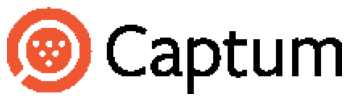

In [2]:
# Use ImageTensor.open() with a URL or filepath to load an image
t = opt.ImageTensor.open(
    "https://raw.githubusercontent.com/pytorch/captum/master/website/static/img/captum_logo.png"
)
# Use show() to quickly view the image.
t.show()

## InputOptimization

`InputOptimization` is the core function for visualizing features with `captum.optim`.

It takes four arguments:
- **`model`** The model whose feature(s) we are visualizing
- **`loss_function`** The loss function that we are optimizing for
- **`input_param`** A `torch.nn.Module` object that generates inputs to the model (e.g. `captum.optim.images.NaturalImage`)
- **`transform`** A transformation or series of transformations preprocessing the input before passing to the model

In [3]:
# Load the model
model = alexnet(pretrained=True).to(device)

# Initialize an input - NaturalImage uses FFT parameterization and color decorrelation
image = opt.images.NaturalImage((224, 224)).to(device) # This creates a Module that returns an ImageTensor

# Initialize a series of transformations
transforms = torch.nn.Sequential(
    # Normalization for torchvision models
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Random translation, scaling, and rotation to help with visualization quality.
    # Padding is used to avoid transform artifacts and then it's cropped away.
    torch.nn.ReflectionPad2d(16),
    opt.transform.RandomSpatialJitter(16),
    opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5,5)),
    opt.transform.RandomSpatialJitter(8),
    opt.transform.CenterCrop((224,224)),
)

# Choose a target layer to optimize
target = model.features[1]

# Create a loss function based on the target layer
loss_fn = opt.loss.ChannelActivation(target, 5)

# Initialize InputOptimization
obj = opt.InputOptimization(model, loss_fn, image, transforms)

## InputOptimization.optimize

After initializing `InputOptimization`, we run the `optimize` method to begin optimizing the visualization.

The `optimize` method returns a `Tensor` object that comprises the loss history.

  0%|          | 0/512 [00:00<?, ? step/s]

There are 512 steps in the history.
Initial loss is -0.15433761477470398.
Final loss is -7.492886066436768.


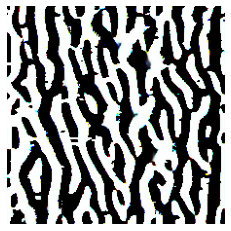

In [4]:
history = obj.optimize()

print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")

image().show()

The `optimize` method also takes 4 optional arguments.
- **stop_criteria** A `Callable` that determines the stopping criteria and takes the following arguments
    - **step** `int` representing number of steps
    - **obj** `InputOptimization` instance
    - **history** `Iterable` of `torch.Tensor` representing loss history
    - **optim** `torch.optim.Optimizer` instance
- **optimizer** An initialized `torch` optimizer instance, this default to an instance of `torch.optim.Adam`
- **loss_summarize_fn** A function that summarizes the loss (refer to the `CustomModules` tutorial for details)
- **lr** Learning rate for default optimizer, defaults to 0.025

For the purposes of this starter tutorial, we will focus on how to change the number of steps for optimization. You can do this with the `optim.optimization.n_steps` function.

For more details on the `optimize` method, refer to the `CustomModules` tutorial.

  0%|          | 0/16 [00:00<?, ? step/s]

There are 16 steps in the history.
Initial loss is -0.15400776267051697.
Final loss is -2.4480137825012207.


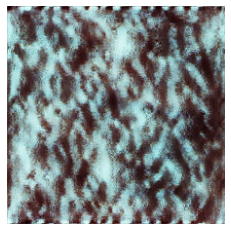

In [5]:
obj = opt.InputOptimization(model, loss_fn, opt.images.NaturalImage((224, 224)).to(device), transforms)

# Use optim.optimization.n_steps to control number of steps
history = obj.optimize(opt.optimization.n_steps(16))

print(f"""There are {len(history)} steps in the history.
Initial loss is {history[0].item()}.
Final loss is {history[-1].item()}.""")

# Another way to retrieve the image is via `input_param()`
obj.input_param().show()

For convenience, we can create a helper function for visualizing different layers in our model.

In [6]:
def visualize(model, target, channel=-1, lr=0.025):
    image = opt.images.NaturalImage((224, 224)).to(device)
    transforms = [
        # Normalization for torchvision models
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # Random translation, scaling, and rotation to help with visualization quality.
        # Padding is used to avoid transform artifacts and then it's cropped away.
        torch.nn.ReflectionPad2d(16),
        opt.transform.RandomSpatialJitter(16),
        opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.CenterCrop((224,224)),
    ]
    transforms = torch.nn.Sequential(*transforms)
    if isinstance(model, opt.models.InceptionV1):
        # For the GoogLeNet model, we don't need the initial normalization
        transforms = transforms[1:]
    if channel > -1:
        loss_fn = opt.loss.ChannelActivation(target, channel)
    else:
        loss_fn = opt.loss.DeepDream(target)
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(128), lr=lr)
    image().show()

With visualization, we can see that deeper features detect for increasingly complex elements.

  0%|          | 0/128 [00:00<?, ? step/s]

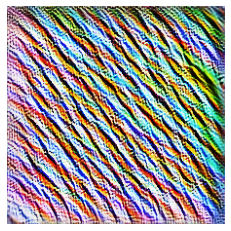

In [7]:
visualize(model, model.features[4], 15)

  0%|          | 0/128 [00:00<?, ? step/s]

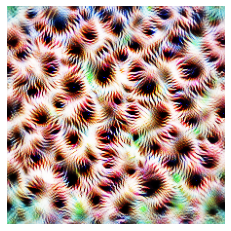

In [8]:
visualize(model, model.features[9], 8)

We can also visualize different classes in the final layer and see how they are similar to their corresponding ImageNet labels.

  0%|          | 0/128 [00:00<?, ? step/s]

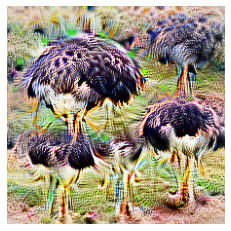

In [9]:
visualize(model, model.classifier[6], 9) # Ostrich

  0%|          | 0/128 [00:00<?, ? step/s]

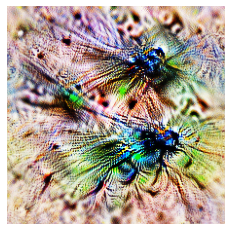

In [10]:
visualize(model, model.classifier[6], 319) # Dragonfly

## Redirected ReLU

In some cases, the neuron of interest may not be activated at all by the initial random input. If this is a ReLU neuron, the zero derivative stops gradient flow backwards and we never move towards any meaningful visualization.

  0%|          | 0/128 [00:00<?, ? step/s]

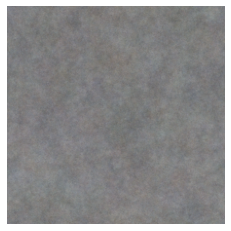

In [11]:
visualize(model, model.features[11], 14) # This will often be a grey-ish output

To remedy that, we designed a RedirectedReLU layer that replaces the usual ReLU. The RedirectedReLU temporarily allows gradient flow when it detects a neuron that is not activated.

  0%|          | 0/128 [00:00<?, ? step/s]

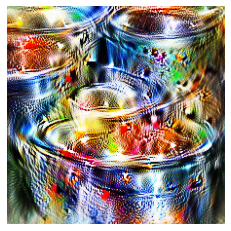

In [12]:
# Replace the regular ReLU with RedirectedReLuLayer
opt.models.replace_layers(model, layer1=torch.nn.ReLU, layer2=opt.models.RedirectedReluLayer)
visualize(model, model.features[11], 14) # This should NOT be grey

## More Models

`captum.optim` is compatible with most `torchvision` models, so feel free to try out other models!

  0%|          | 0/128 [00:00<?, ? step/s]

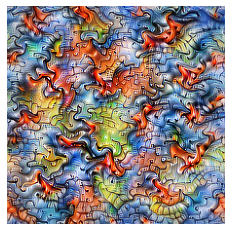

In [13]:
from torchvision.models import vgg16 # Torchvision's VGG-16 model
model = vgg16(pretrained=True).to(device)
visualize(model, model.features[26], 50)

### GoogLeNet

`captum.optim` also comes with the GoogLeNet `inception5h` model that can be used to reproduce examples from Lucid! For more examples, check out the `ReproduceLucid_OptimViz` notebook.

  0%|          | 0/128 [00:00<?, ? step/s]

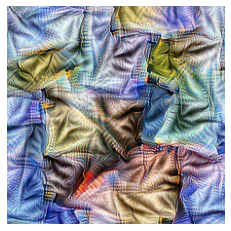

In [14]:
from captum.optim.models import googlenet
model = googlenet(pretrained=True).to(device)
visualize(model, model.mixed4c, 368)

  0%|          | 0/128 [00:00<?, ? step/s]

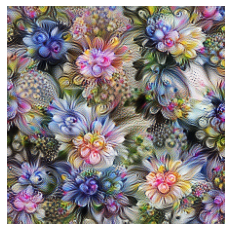

In [15]:
visualize(model, model.mixed4d.conv_3x3_reduce, 139)